# DeepDecolor: Perception Preserving Decolorization
### Bolun Cai, Xiangmin Xu, Xiaofen Xing

**Abstract: **Decolorization is a basic tool to transform a color image into a grayscale image, which is used in digital printing, stylized
black-and-white photography, and in many single-channel image processing applications. While recent researches focus on retaining as much as possible meaningful visual features and color contrast. In this paper, we explore how to use deep neural networks for decolorization, and propose an optimization approach aiming at perception preserving. The system uses deep representations to extract content information based on human visual perception, and automatically selects suitable grayscale for decolorization. The evaluation experiments show the effectiveness of the proposed method. effectiveness of the proposed method.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from utils import *

import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
use_cuda = torch.cuda.is_available()

In [2]:
vgg = models.vgg19(pretrained=True).features
if use_cuda: vgg = vgg.cuda()

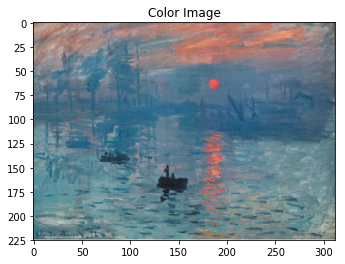

In [3]:
color_img = imread("images/20.png")
if use_cuda: color_img = color_img.cuda()
imshow(color_img.data, title='Color Image')

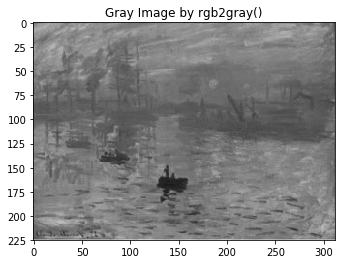

In [4]:
rgb2gray = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale(), transforms.ToTensor()])
tensor = color_img.view(color_img.size(1), color_img.size(2), color_img.size(3))
gray_img = rgb2gray(tensor.cpu()).unsqueeze(0)
imshow(gray_img, title='Gray Image by rgb2gray()', cmap='gray')

In [5]:
gray_img = torch.randn(gray_img.data.size())
if use_cuda: gray_img = gray_img.cuda()
    
lr = 0.5        #initial learning rate
mu = 1e-4       #updatad threshold
gamma = 0.5     #learning rate is updated by half
min_lr = 1e-3   #min learning rate
max_iter = 2000 #max iteration
perceptual_layers = ['layer_1', 'layer_2', 'layer_4', 'layer_8', 'layer_12']
perceptual_weights = [1, 1, 0.5, 0.25, 0.125]

model, losses = DecolorNet(vgg, color_img, use_cuda, perceptual_layers, perceptual_weights)
repeat = TileLayer(3)
input_param = nn.Parameter(gray_img.data)
optimizer = optim.Adam([input_param], lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=gamma, threshold=mu, min_lr=min_lr, patience=50)

pre_loss = float("inf")
for iter_num in range(0, max_iter):
    input_param.data.clamp_(0, 1)
    optimizer.zero_grad()
    
    model(repeat(input_param))
    total_loss = 0 
    for loss in losses:
        total_loss += loss.backward()
    optimizer.step()
    scheduler.step(total_loss.item())
    if iter_num % 200 == 0:
        print('[%04d/%04d]: Perceptual Loss = %0.4f'%(iter_num, max_iter, total_loss.item()))
        if pre_loss - total_loss.item() < mu:
            break
        pre_loss = total_loss.item()
print('Finish optimization: Perceptual Loss = %0.4f'%total_loss.item())

[0000/2000]: Perceptual Loss = 18.8702
[0200/2000]: Perceptual Loss = 0.8184
[0400/2000]: Perceptual Loss = 0.3508
[0600/2000]: Perceptual Loss = 0.3461
[0800/2000]: Perceptual Loss = 0.3456
[1000/2000]: Perceptual Loss = 0.3456
Finish optimization: Perceptual Loss = 0.3456


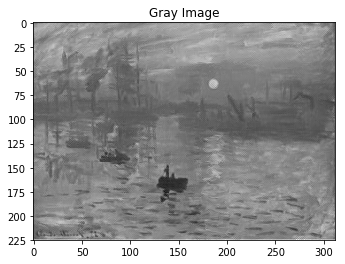

In [6]:
gray_img = input_param.data.clamp_(0, 1)
imshow(gray_img, title='Gray Image', cmap='gray', filename='gray.png')